# Implementation of Boundary Equilibrium GANs
Reference: https://arxiv.org/pdf/1703.10717

### Introduction
In this task, we can use BEGAN to generate human face.    
The dataset is a subset of CelebA.    
1, we need to finetune the net G and D.    
2, we can test how the net G generate fake faces.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
import datetime
import os, sys

In [3]:
import glob

In [4]:
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'BEGAN'
DEVICE = torch.device("cpu")

In [7]:
IMAGE_DIM = (32, 32, 3)

In [8]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

In [9]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [10]:
class Encoder(nn.Module):
    """
        Convolutional Encoder
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=100):
        super(Encoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.conv = nn.Sequential(
            # conv0
            nn.Conv2d(in_channel, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters*2, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv3
            nn.Conv2d(n_filters*2, n_filters*2, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters*2, n_filters*3, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv5
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(self.flatten_dim**2*n_filters*3, hidden_dim)
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

In [11]:
class Decoder(nn.Module):
    """
        Convolutional Decoder
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=100):
        super(Decoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.fc = nn.Sequential(
            nn.Linear(n_noise, self.flatten_dim**2*n_filters),
        )
        self.conv = nn.Sequential(
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv3
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv5
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, out_channel, 3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )
    
    def forward(self, h):
        h = self.fc(h)
        h = h.view(h.size(0), -1, self.flatten_dim, self.flatten_dim)
        x = self.conv(h)
        return x

In [12]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.encoder = Encoder(in_channel=in_channel, n_filters=n_filters, hidden_dim=hidden_dim)
        self.decoder = Decoder(out_channel=in_channel, n_filters=n_filters, n_noise=hidden_dim)
        
    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        return x_

In [13]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=64):
        super(Generator, self).__init__()
        self.decoder = Decoder(out_channel=out_channel, n_filters=n_filters, n_noise=n_noise)
        
    def forward(self, h):
        x_ = self.decoder(h)
        return x_

In [14]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ])

CelebA-ch subset download: [link](https://drive.google.com/file/d/1RD55pZnakqEZn3FMPaoB2c1ShaouJJ_1/view?usp=sharing)    
unzip it and put into current dir.

In [38]:
dataset = datasets.ImageFolder(root='./celeba', transform=transform)
print('This subset dataset has {} images'.format(len(dataset)))

This subset dataset has 402 images


In [16]:
batch_size = 32
n_noise = 64

In [17]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)

## build network G and D

In [18]:
D = Discriminator(in_channel=IMAGE_DIM[-1], hidden_dim=n_noise).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

## Load pretrained G and D
Train a full network needs GPU and many times. So we can finetune the network on the provided pretrained model. 

download pretrained network: [link](https://drive.google.com/file/d/1p43gmCvWmrBbOJSjIsJtLOBfOJ1yN8ei/view?usp=sharing)    
put into current dir.

In [41]:
pretrained_path = './began_pretrained.pth.tar'
state = torch.load(pretrained_path,map_location=lambda storage, loc: storage)
G.load_state_dict(state['G'])
D.load_state_dict(state['D'])

<All keys matched successfully>

In [42]:
lr_G = 0.00002
lr_D = 0.00002
D_opt = torch.optim.Adam(D.parameters(), lr=lr_G, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=lr_D, betas=(0.5, 0.999))

In [43]:
# BEGAN causes mode collapse. it can be addressed by decaying lr
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [44]:
criterion = nn.L1Loss()

In [47]:
max_epoch = 1
lr_k = 0.001
gamma = 0.7
k_t = 0
log_term = 1

In [48]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

12

In [49]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

In [50]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

## Training

In [51]:
m_lst = []
bestM = 1.
for epoch in range(max_epoch):
    step = 0
    
    for idx, (images, labels) in enumerate(data_loader):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, x)

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = criterion(z_outputs, x_fake)
        
        D_loss = D_x_loss - k_t*D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = criterion(x_fake, z_outputs)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        bal = (gamma*D_x_loss - G_loss).detach()
        k_t = min(max(k_t + lr_k*bal, 0), 1)
        M_global = D_x_loss.detach() + torch.abs(bal)
        
        
        if step % log_term == 0:
            m_lst.append(M_global)
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}/{}, D Loss: {:.4f}, G Loss: {:.4f}, k: {:.4f}, M: {:.4f}, lr: {:.7f}, Time:{}'.format(epoch, max_epoch, step, steps_per_epoch, D_loss.item(), G_loss.item(), k_t, M_global.item(), G_scheduler.get_lr()[0], dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
    D_scheduler.step()
    G_scheduler.step()

Epoch: 0/1, Step: 0/12, D Loss: 0.0896, G Loss: 0.0551, k: 0.0000, M: 0.0972, lr: 0.0000200, Time:20:21:02
Epoch: 0/1, Step: 1/12, D Loss: 0.0928, G Loss: 0.0488, k: 0.0000, M: 0.1089, lr: 0.0000200, Time:20:21:14
Epoch: 0/1, Step: 2/12, D Loss: 0.0903, G Loss: 0.0483, k: 0.0000, M: 0.1053, lr: 0.0000200, Time:20:21:26
Epoch: 0/1, Step: 3/12, D Loss: 0.0894, G Loss: 0.0486, k: 0.0001, M: 0.1034, lr: 0.0000200, Time:20:21:39
Epoch: 0/1, Step: 4/12, D Loss: 0.0852, G Loss: 0.0484, k: 0.0001, M: 0.0964, lr: 0.0000200, Time:20:21:51
Epoch: 0/1, Step: 5/12, D Loss: 0.0901, G Loss: 0.0483, k: 0.0001, M: 0.1048, lr: 0.0000200, Time:20:22:03
Epoch: 0/1, Step: 6/12, D Loss: 0.0891, G Loss: 0.0479, k: 0.0001, M: 0.1036, lr: 0.0000200, Time:20:22:16
Epoch: 0/1, Step: 7/12, D Loss: 0.0859, G Loss: 0.0468, k: 0.0001, M: 0.0992, lr: 0.0000200, Time:20:22:28
Epoch: 0/1, Step: 8/12, D Loss: 0.0920, G Loss: 0.0486, k: 0.0001, M: 0.1078, lr: 0.0000200, Time:20:22:40
Epoch: 0/1, Step: 9/12, D Loss: 0.082

In [52]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/began{:06d}.pth.tar'.format(step))

## Testing

### 1. Load the trained model

In [20]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-1]
state = torch.load(G_path,map_location=lambda storage, loc: storage)
G.load_state_dict(state['G'])

<All keys matched successfully>

In [21]:
G.eval()
None

### 2. Input noise to net G, output generated face images.

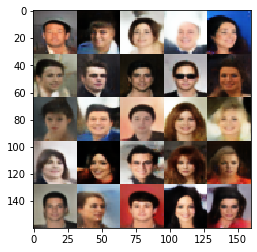

In [54]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

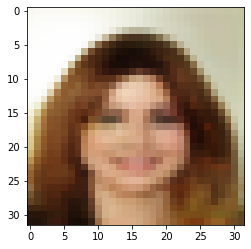

In [55]:
# Fake Image
idx = [2, 3]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

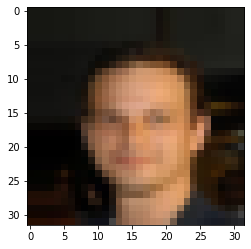

In [57]:
# Real Image from dataset
i = 15
images, labels = dataset[i]
rimg = tensor2img(dataset[i][0])
imshow(rimg)

### 3. Input Interpolated noise, output gradual face images

In [70]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [71]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(DEVICE)
zs = torch.transpose(zs, 0, 1)
zs.shape

torch.Size([10, 64])

In [72]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

torch.Size([3, 32, 320])

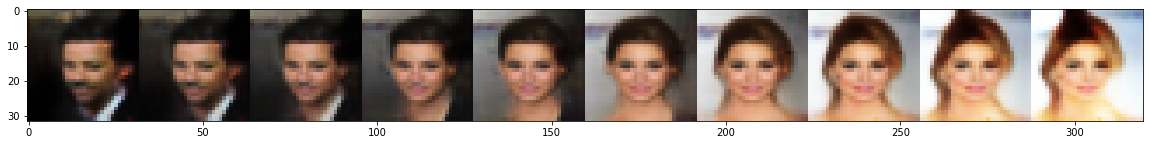

In [73]:
fig = plt.figure(figsize=(20, 3))
imshow(tensor2img(imgs))